<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

This will save files to your local machine if `save_files` is set to True.

# Change Inputs Here

In [1]:
task = "numerals"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 4 #768 512

# model_name = "gpt2-small"

save_files = True
run_on_other_tasks = True

# Setup

In [2]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [4]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

## Load Model

In [6]:
# model = HookedTransformer.from_pretrained(
#     model_name,
#     center_unembed=True,
#     center_writing_weights=True,
#     fold_ln=True,
#     refactor_factored_attn_matrices=True,
# )

In [7]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [8]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [9]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

# tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)
tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH, use_fast= False, add_prefix_space= False)
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [10]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [11]:
tl_model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [12]:
model = tl_model

In [13]:
# Get list of arguments to pass to `generate` (specifically these are the ones relating to sampling)
generate_kwargs = dict(
    do_sample = False, # deterministic output so we can compare it to the HF model
    top_p = 1.0, # suppresses annoying output errors
    temperature = 1.0, # suppresses annoying output errors
)

prompt = "The capital of Germany is"

In [14]:
tl_model = tl_model.to("cuda" if torch.cuda.is_available() else "cpu")

output = tl_model.generate(prompt, max_new_tokens=20, **generate_kwargs)

print(output)

Moving model to device:  cuda


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


# Import functions from repo

In [15]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/iter_node_pruning

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 760, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 760 (delta 119), reused 173 (delta 68), pack-reused 534
Receiving objects: 100% (760/760), 16.15 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (482/482), done.
/content/seqcont_circuits/src/iter_node_pruning


In [16]:
# from dataset import Dataset
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

# Functions

In [17]:
class Dataset:
    def __init__(self, prompts, pos_dict, tokenizer):  # , S1_is_first=False
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[-1] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[-1] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = self.tokenizer.tokenize(input_text)
                # if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                #     target_token = prompt[targ]
                # else:
                #     target_token = "Ġ" + prompt[targ]
                # target_index = tokens.index(target_token)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

# Load datasets

In [18]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S0': str(i),
            'S1': str(i+1),
            'S2': str(i+2),
            'S3': str(i+3),
            'corr': str(i+4),
            'incorr': str(i+3),
            'text': f"{i} {i+1} {i+2} {i+3} "
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 6)

In [19]:
pos_dict = {}
for i in range(len(model.tokenizer.tokenize(prompts_list[0]['text']))):
    pos_dict['S'+str(i)] = i

In [20]:
dataset = Dataset(prompts_list, pos_dict, model.tokenizer)

In [21]:
import random

def generate_prompts_list_corr(x ,y):
    prompts_list = []
    for i in range(x, y):
        r1 = random.randint(1, 9)
        r2 = random.randint(1, 9)
        while True:
            r3 = random.randint(1, 9)
            r4 = random.randint(1, 9)
            if r4 - 1 != r3:
                break
        prompt_dict = {
            'S0': str(r1),
            'S1': str(r2),
            'S2': str(r3),
            'S3': str(r4),
            'corr': str(i+4),
            'incorr': str(i+3),
            'text': f"{r1} {r2} {r3} {r4} "
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list_2 = generate_prompts_list_corr(1, 6)
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer) #, S1_is_first=True)

## large ds

In [22]:
# prompts_list = []

# for i in prompt_types:
#     file_name = f'/content/seqcont_circuits/data/{task}/{task}_prompts_{i}.pkl'
#     with open(file_name, 'rb') as file:
#         filelist = pickle.load(file)

#     print(filelist[0]['text'])
#     prompts_list += filelist [:num_samps_per_ptype]

# len(prompts_list)

In [23]:
# %%capture
# dataset = Dataset(prompts_list, pos_dict, model.tokenizer)

In [24]:
# file_name = f'/content/seqcont_circuits/data/{task}/randDS_{task}.pkl'
# with open(file_name, 'rb') as file:
#     prompts_list_2 = pickle.load(file)

In [25]:
# dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer)

# Get orig score

In [26]:
model.reset_hooks(including_permanent=True)
logits_original = model(dataset.toks)
orig_score = get_logit_diff(logits_original, dataset)

In [27]:
orig_score

tensor(2.3343, device='cuda:0')

In [28]:
import gc

del(logits_original)
torch.cuda.empty_cache()
gc.collect()

151

# Find Impt Attention Heads from Full

Llama-2 has 32 heads per layer

In [35]:
SEQ_POS_TO_KEEP = {}
for i in range(len(model.tokenizer.tokenize(dataset_2.prompts[-1]['text']))):
    # CIRCUIT['S'+str(i)] = lst
    if i == len(model.tokenizer.tokenize(dataset_2.prompts[-1]['text'])) - 1:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
    else:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
SEQ_POS_TO_KEEP

{'S0': 'S0',
 'S1': 'S1',
 'S2': 'S2',
 'S3': 'S3',
 'S4': 'S4',
 'S5': 'S5',
 'S6': 'S6',
 'S7': 'end'}

In [36]:
for i in range(0, 5):
    print(model.tokenizer.tokenize(dataset_2.prompts[i]['text']))

['8', '▁', '1', '▁', '3', '▁', '6', '▁']
['2', '▁', '9', '▁', '8', '▁', '6', '▁']
['7', '▁', '9', '▁', '7', '▁', '7', '▁']
['7', '▁', '4', '▁', '8', '▁', '1', '▁']
['8', '▁', '8', '▁', '1', '▁', '5', '▁']


In [37]:
lst = [(layer, head) for layer in range(32) for head in range(0, 32)]
CIRCUIT = {}
SEQ_POS_TO_KEEP = {}
for i in range(len(model.tokenizer.tokenize(dataset_2.prompts[0]['text']))):
    CIRCUIT['S'+str(i)] = lst
    if i == len(model.tokenizer.tokenize(dataset_2.prompts[0]['text'])) - 1:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
    else:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

new_score = get_logit_diff(ioi_logits_minimal, dataset)

In [38]:
new_score

tensor(2.3343, device='cuda:0')

In [39]:
circ = [(layer, head) for layer in range(32) for head in range(0, 32)]
# to_loop = circ.copy() # (L,H) to remove
# to_loop = [(layer, head) for layer in range(32) for head in range(29, 30)]
to_loop = [(layer, head) for layer in range(32) for head in range(0, 32)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 96.9078
removed: (0, 1)
Average logit difference (circuit / full) %: 100.6053
removed: (0, 2)
Average logit difference (circuit / full) %: 96.9038
removed: (0, 3)
Average logit difference (circuit / full) %: 99.1947
removed: (0, 4)
Average logit difference (circuit / full) %: 104.2715
removed: (0, 5)
Average logit difference (circuit / full) %: 100.2262
removed: (0, 6)
Average logit difference (circuit / full) %: 100.8114
removed: (0, 7)
Average logit difference (circuit / full) %: 102.7577
removed: (0, 8)
Average logit difference (circuit / full) %: 99.9334
removed: (0, 9)
Average logit difference (circuit / full) %: 91.1199
removed: (0, 10)
Average logit difference (circuit / full) %: 97.1909
removed: (0, 11)
Average logit difference (circuit / full) %: 98.1268
removed: (0, 12)
Average logit difference (circuit / full) %: 100.3233
removed: (0, 13)
Average logit difference (circuit / full) %: 99.1977
removed: (0, 14)
Average

In [40]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
i=1
for lh, score in sorted_lh_scores[:30]:
    modified_score = -round(100 - score, 2)
    print(i, lh, modified_score)
    i+=1

1 (20, 17) -112.58
2 (16, 0) -70.09
3 (1, 11) -29.55
4 (5, 25) -18.19
5 (3, 24) -17.29
6 (6, 11) -14.28
7 (4, 3) -13.74
8 (0, 14) -13.54
9 (8, 0) -13.02
10 (7, 30) -12.45
11 (31, 4) -11.78
12 (17, 12) -10.46
13 (10, 1) -9.82
14 (26, 2) -9.75
15 (6, 5) -9.5
16 (23, 2) -9.05
17 (30, 13) -8.92
18 (0, 9) -8.88
19 (29, 30) -8.56
20 (19, 11) -8.37
21 (7, 0) -8.11
22 (2, 2) -8.09
23 (8, 15) -7.86
24 (14, 7) -7.28
25 (15, 25) -7.02
26 (23, 27) -7.0
27 (19, 2) -6.92
28 (26, 30) -6.87
29 (9, 13) -6.77
30 (12, 18) -6.76


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

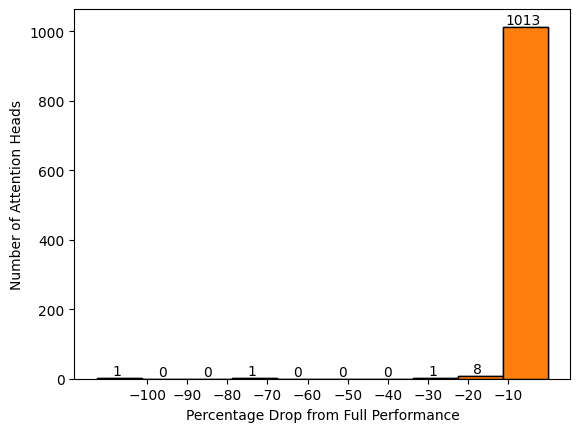

In [41]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# plt.show()

if save_files:
    pdf_filename = 'lh_scores_distribution.pdf'
    plt.savefig(pdf_filename)
    files.download(pdf_filename)

In [42]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)
if save_files:
    with open('numerals_lh_scores.pkl', 'wb') as file:
        pickle.dump(lh_scores, file)
        files.download('numerals_lh_scores.pkl')

Mean of the scores: -0.9603427806869149


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Find Impt MLPs from Full

In [ ]:
for i in range(32):
    lst = [layer for layer in range(32) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

# Node Ablation Iteration

In [ ]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    old_circ_heads = curr_circ_heads.copy() # save old before finding new one
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circ_heads = curr_circ_heads.copy()
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    iter += 1


backw prune, iter  1
11
(cand circuit / full) %: 78.8354
11 0
(cand circuit / full) %: 99.7405
Removed: (11, 0)
11 1
(cand circuit / full) %: 100.1990
Removed: (11, 1)
11 2
(cand circuit / full) %: 100.6725
Removed: (11, 2)
11 3
(cand circuit / full) %: 101.3111
Removed: (11, 3)
11 4
(cand circuit / full) %: 101.5750
Removed: (11, 4)
11 5
(cand circuit / full) %: 101.8257
Removed: (11, 5)
11 6
(cand circuit / full) %: 102.0605
Removed: (11, 6)
11 7
(cand circuit / full) %: 102.3034
Removed: (11, 7)
11 8
(cand circuit / full) %: 100.9598
Removed: (11, 8)
11 9
(cand circuit / full) %: 100.5795
Removed: (11, 9)
11 10
(cand circuit / full) %: 99.2775
Removed: (11, 10)
11 11
(cand circuit / full) %: 100.1830
Removed: (11, 11)
10
(cand circuit / full) %: 63.1566
10 0
(cand circuit / full) %: 100.2873
Removed: (10, 0)
10 1
(cand circuit / full) %: 99.4857
Removed: (10, 1)
10 2
(cand circuit / full) %: 101.9172
Removed: (10, 2)
10 3
(cand circuit / full) %: 102.0514
Removed: (10, 3)
10 4
(can

In [ ]:
with open('numerals_bf_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('numerals_bf_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
curr_circ_heads

[(0, 1),
 (1, 5),
 (4, 4),
 (4, 10),
 (5, 0),
 (6, 1),
 (6, 6),
 (6, 10),
 (7, 11),
 (8, 1),
 (8, 6),
 (8, 8),
 (8, 9),
 (9, 1)]

In [ ]:
curr_circ_mlps

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

## Find most impt heads from circ

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.0075


In [ ]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 1)
(cand circuit / full) %: 36.7208
removed: (1, 5)
(cand circuit / full) %: 53.1754
removed: (4, 4)
(cand circuit / full) %: 47.8225
removed: (4, 10)
(cand circuit / full) %: 76.1406
removed: (5, 0)
(cand circuit / full) %: 75.9876
removed: (6, 1)
(cand circuit / full) %: 70.7259
removed: (6, 6)
(cand circuit / full) %: 73.4448
removed: (6, 10)
(cand circuit / full) %: 67.0089
removed: (7, 11)
(cand circuit / full) %: 39.3698
removed: (8, 1)
(cand circuit / full) %: 68.0800
removed: (8, 6)
(cand circuit / full) %: 69.9912
removed: (8, 8)
(cand circuit / full) %: 65.7820
removed: (8, 9)
(cand circuit / full) %: 76.9148
removed: (9, 1)
(cand circuit / full) %: 46.0634


In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(0, 1) -0.98
(7, 11) 1.67
(9, 1) 8.36
(4, 4) 10.12
(1, 5) 15.48
(8, 8) 28.08
(6, 10) 29.31
(8, 1) 30.38
(8, 6) 32.29
(6, 1) 33.03
(6, 6) 35.74
(5, 0) 38.29
(4, 10) 38.44
(8, 9) 39.21


# Run on other task's circuits

In [ ]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.0075


In [ ]:
# numwords
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 8), (6, 1), (6, 6), (6, 10), (7, 2), (7, 6), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (9, 5), (9, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 87.3488


In [ ]:
# months
heads_not_ablate = [(0, 1), (0, 5), (4, 4), (6, 1), (6, 6), (6, 10), (7, 6), (7, 9), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 43.7440


In [ ]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

import itertools
a = [val for val in CIRCUIT.values()]
IOI_heads = list(itertools.chain.from_iterable(a))

mlps_not_ablate = list(range(12))

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, IOI_heads, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: -6.6992


In [ ]:
### months w/ MLP 11

heads_not_ablate = [(0, 1), (4, 4), (4, 10), (6, 1), (6, 6), (6, 10), (7, 2), (7, 10), (7, 11), (8, 8), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11] # incl 5 makes it 66.1155%

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 37.7001
